<a href="https://colab.research.google.com/github/enerdb/Data-Camp-Courses/blob/main/handwritten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST
MNIST dataset has 70000 images of digits. This code aims at classifing these images.

In [66]:
%matplotlib inline

In [ ]:
from sklearn.datasets import fetch_openml

import numpy as np

In [ ]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [27]:
X, y = mnist['data'].values, mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


(-0.5, 27.5, 27.5, -0.5)

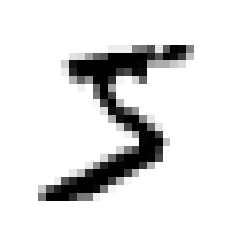

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt

digit0 = X[0]
digit0_image = digit0.reshape(28,28)

plt.imshow(digit0_image, cmap='binary')
plt.axis('off')

In [ ]:
y[0]


'5'

In [28]:


y = y.astype(np.uint8)

In [29]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier


Creating a 5-detector

In [31]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

In [32]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [38]:
sgd_clf.predict([digit0])


array([ True])

## Performance Measures


In [42]:
# Implementing Cross-Validation
# This code does the same as sklearn's cross_val_score()
# from sklearn.model_selection import cross_val_score
# cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)#, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


This dumb classifier always predicts not 5 and has 90% accuracy because only 10% of the dataset is made of 5s:

In [45]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class Never5Classifier(BaseEstimator):

    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [46]:
from sklearn.model_selection import cross_val_predict

# returns predictions made on each test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 


In [47]:
y_train_pred


array([ True, False, False, ...,  True, False, False])

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric.

Precision = TP / (TP+FP)

Recall = Sensitivity = True Positive Rate (TPR) = TP / (TP+FN)


In [52]:
from sklearn.metrics import precision_score, recall_score

print('precision: ', precision_score(y_train_5, y_train_pred))
print('recall: ', recall_score(y_train_5, y_train_pred))


precision:  0.8370879772350012
recall:  0.6511713705958311


F1 score is the harmonic mean of precision and recall

In [53]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

### Precision/Recall Trade-off


In [55]:
y_scores = sgd_clf.decision_function([digit0])
y_scores

array([2164.22030239])

In [61]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [62]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)



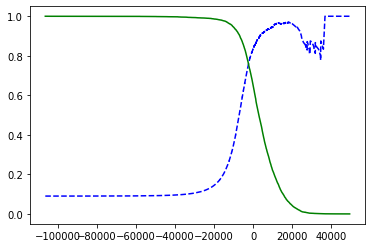

In [68]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    #[...] # highlight the threshold and add the legend, axis label, and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

To aim at a fixed precision target

In [69]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 

In [70]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [71]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [72]:
recall_score(y_train_5, y_train_pred_90)


0.4799852425751706

## The ROC Curve